In [2]:
import numpy as np
import pandas as pd
import PIL
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.preprocessing import image

Samples Training Set: 6999
Samples in Validation Data: 1500
Samples in Test Data: 1500
Batch size: 8
Epoch 1/10
875/875 [==============================] - 40s 42ms/step - loss: 0.5767 - precision: 0.6921 - recall: 0.6096 - binary_accuracy: 0.7184 - val_loss: 0.3630 - val_precision: 0.8499 - val_recall: 0.7830 - val_binary_accuracy: 0.8527
Epoch 2/10
875/875 [==============================] - 35s 40ms/step - loss: 0.3526 - precision: 0.8334 - recall: 0.8130 - binary_accuracy: 0.8513 - val_loss: 0.2688 - val_precision: 0.8643 - val_recall: 0.8601 - val_binary_accuracy: 0.8860
Epoch 3/10
875/875 [==============================] - 38s 43ms/step - loss: 0.3024 - precision: 0.8642 - recall: 0.8546 - binary_accuracy: 0.8810 - val_loss: 0.2624 - val_precision: 0.8879 - val_recall: 0.8280 - val_binary_accuracy: 0.8853
Epoch 4/10
875/875 [==============================] - 38s 43ms/step - loss: 0.2879 - precision: 0.8615 - recall: 0.8708 - binary_accuracy: 0.8854 - val_loss: 0.2484 - val_precisio

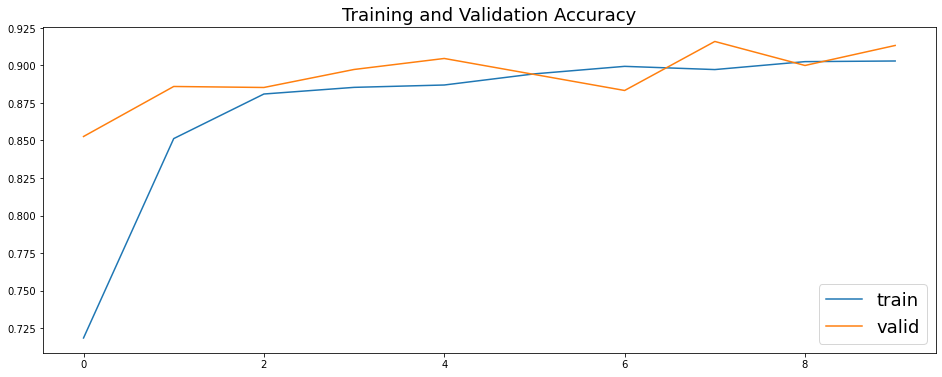

INFO:tensorflow:Assets written to: cnn85_checkpoints/iter1\assets
Model 1evaluating:
47/47 [==============================] - 2s 37ms/step - loss: 0.2204 - precision: 0.8832 - recall: 0.9116 - binary_accuracy: 0.9133
model loaded: iter1
training model 2
Samples Training Set: 6999
Samples in Validation Data: 1500
Samples in Test Data: 1500
Batch size: 8
SGD
Epoch 1/10
875/875 [==============================] - 31s 34ms/step - loss: 0.2308 - precision: 0.8872 - recall: 0.9012 - binary_accuracy: 0.9093 - val_loss: 0.2255 - val_precision: 0.8847 - val_recall: 0.8928 - val_binary_accuracy: 0.9027
Epoch 2/10
875/875 [==============================] - 31s 35ms/step - loss: 0.2160 - precision: 0.8964 - recall: 0.9043 - binary_accuracy: 0.9148 - val_loss: 0.2215 - val_precision: 0.8926 - val_recall: 0.8913 - val_binary_accuracy: 0.9060
Epoch 3/10
875/875 [==============================] - 31s 35ms/step - loss: 0.2070 - precision: 0.8981 - recall: 0.9059 - binary_accuracy: 0.9163 - val_loss: 0.2

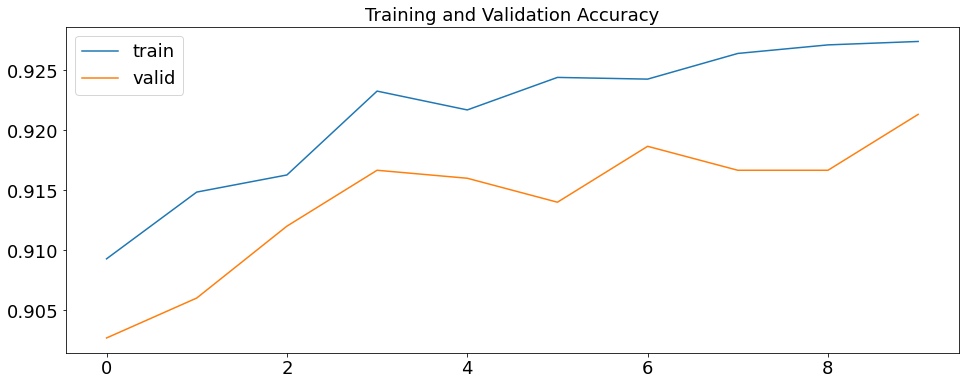

INFO:tensorflow:Assets written to: cnn85_checkpoints/iter2\assets
Model 2evaluating:
47/47 [==============================] - 2s 32ms/step - loss: 0.2029 - precision: 0.9122 - recall: 0.9066 - binary_accuracy: 0.9213
model loaded: iter2
training model 3
Samples Training Set: 6999
Samples in Validation Data: 1500
Samples in Test Data: 1500
Batch size: 8
SGD
Epoch 1/10
875/875 [==============================] - 31s 34ms/step - loss: 0.2040 - precision: 0.8978 - recall: 0.9049 - binary_accuracy: 0.9184 - val_loss: 0.1751 - val_precision: 0.9257 - val_recall: 0.9008 - val_binary_accuracy: 0.9320
Epoch 2/10
875/875 [==============================] - 31s 36ms/step - loss: 0.1985 - precision: 0.9038 - recall: 0.9160 - binary_accuracy: 0.9253 - val_loss: 0.1760 - val_precision: 0.9370 - val_recall: 0.8992 - val_binary_accuracy: 0.9360
Epoch 3/10
875/875 [==============================] - 32s 37ms/step - loss: 0.1988 - precision: 0.9006 - recall: 0.9084 - binary_accuracy: 0.9210 - val_loss: 0.1

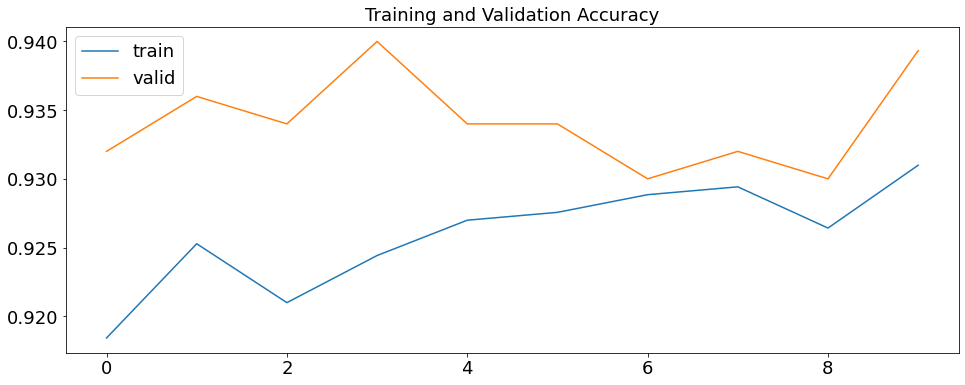

INFO:tensorflow:Assets written to: cnn85_checkpoints/iter3\assets
Model 3evaluating:
47/47 [==============================] - 2s 33ms/step - loss: 0.1710 - precision: 0.9406 - recall: 0.9042 - binary_accuracy: 0.9393
model loaded: iter3
training model 4
Samples Training Set: 6999
Samples in Validation Data: 1500
Samples in Test Data: 1500
Batch size: 8
Epoch 1/10
172/875 [====>.........................] - ETA: 28s - loss: 0.2624 - precision: 0.8767 - recall: 0.8782 - binary_accuracy: 0.8946

KeyboardInterrupt: 

In [6]:
attr_data_path = "list_attr_celeba.csv"
images_data_path = "C:/Users/foreh/Documents/CelebaRepo/FacialAttrCNN/celeba/greyscale"
images_data_size = 10000 

tf.keras.backend.clear_session()
width = 178
height = 218
x_ = 100                            # new value of x
image_size_ratio = width / height    # dimensions ratio
y_ = int(image_size_ratio * x_)  
model = Sequential()
model.add(tf.keras.Input(shape=(height, width,1)))
model.add(tf.keras.layers.Normalization())

model.add(Conv2D(filters=32,kernel_size=(3,3),padding = 'same'))
model.add(Conv2D(filters=8, kernel_size=(3,3), padding='same'))
model.add(tf.keras.layers.Normalization())

model.add(Conv2D(filters=4, kernel_size=(3, 3), padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Dropout(0.2))

model.add(Conv2D(filters=16,kernel_size=(3,3),padding = 'same'))
model.add(Conv2D(filters=8,kernel_size=(2,2),padding = 'same'))
model.add(tf.keras.layers.Normalization())

model.add(Conv2D(filters=4, kernel_size=(3, 3), padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Dropout(0.2))

model.add(Conv2D(filters=16,kernel_size=(3,3),padding = 'same'))
model.add(Conv2D(filters=8,kernel_size=(2,2),padding = 'same'))
## changed from (3,3)->(1,3)
model.add(tf.keras.layers.Normalization())

model.add(Conv2D(filters=4, kernel_size=(3, 3), padding='same'))
model.add(MaxPooling2D(pool_size=4))

model.add(Conv2D(filters=16, kernel_size=(3,3)))
model.add(Conv2D(filters=16, kernel_size=(2,2)))
model.add(tf.keras.layers.AveragePooling2D(pool_size=2))

model.add(tf.keras.layers.Normalization())

model.add(Flatten())
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(48))
model.add(Dense(16))
model.add(Dense(1, activation='sigmoid'))
original_image_size = (width,height)
df_org = pd.read_csv(attr_data_path)

for i in range(1, 100):
    if (i > 1):
        model = tf.keras.models.load_model('cnn85_checkpoints/iter'+str(i-1))
        print("model loaded: iter"+str(i-1))
        print("training model "+str(i))
    df = pd.DataFrame()
    if((i+1) % 20 == 0):
        df = df_org[(1+images_data_size*(i%20)):202600]
    else:
        df = df_org[(1+images_data_size*(i%20)):images_data_size*((i+1)%20)]
    df = df.replace(-1,0)
    #print(df.head(5))
    images_data = list()
    for idx in range(df.shape[0]):
        path = "{}/{}".format(str(images_data_path),str(df.iloc[idx].image_id))
        image = PIL.Image.open(path)
        image_array = np.asarray(image)
        images_data.append(image_array)
    images_data = np.array(images_data)
    def image_from_index(index, size=(original_image_size), path=images_data_path):
        path = "{}/{}".format(str(path),str(df.iloc[index].image_id))
        # to read the image
        image = PIL.Image.open(path).resize(size)
        image_array = np.asarray(image)

        return image_array
    images = images_data # list of array of images
    labels = df[["image_id", "Male"]]  # dataframe of image features
    train_images,test_images,train_labels,test_labels = train_test_split(images,labels,test_size=0.3,random_state=(i%6))
    y_test=test_labels.drop(["image_id"],axis=1)
    y_train=train_labels.drop(["image_id"],axis=1)

    X_test=test_images
    X_train=train_images
    #X_train = tf.expand_dims(X_train, axis=-1)
    print("Samples Training Set:",len(X_train))
    X_test, X_val, y_test, y_val=train_test_split(X_test, y_test,test_size=0.5,random_state=(i%5))
    print("Samples in Validation Data:",len(X_val))
    print("Samples in Test Data:",len(X_test))
    x_ = original_image_size[0]
    y_ = original_image_size[1]
    BATCH_SIZE = (8)
    print("Batch size: " + str(BATCH_SIZE))
    if False or i%3 == 1:
          model.compile(optimizer = "nadam",loss="binary_crossentropy",metrics = [tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'binary_accuracy'])
    elif True or i%3 == 2 or i%3 == 0:
          print("SGD")
          opt = tf.keras.optimizers.SGD(learning_rate=0.001)
          model.compile(optimizer = opt,loss="binary_crossentropy",metrics = [tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'binary_accuracy'])
    else:
          print("ADAM")
          opt = tf.keras.optimizers.Adam(learning_rate=0.003)
          model.compile(optimizer = opt,loss="binary_crossentropy",metrics = [tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'binary_accuracy'])
    # Plot accuracy through epochs
    
    hist = model.fit(X_train,y_train,epochs = 10,validation_data = (X_val,y_val),batch_size=BATCH_SIZE,shuffle = True)
    plt.figure(figsize=(16, 6))
    plt.plot(hist.history['binary_accuracy'], label = 'train')
    plt.plot(hist.history['val_binary_accuracy'], label = 'valid')
    plt.rcParams['ytick.labelsize']=18
    plt.rcParams['xtick.labelsize']=18
    plt.rcParams['axes.labelsize']=18
    plt.legend(fontsize=18)
    plt.title('Training and Validation Accuracy', fontsize=18)
    plt.savefig('accuracy')
    plt.show() 
    model.save('cnn85_checkpoints/iter'+str(i))
    print("Model " + str(i) +"evaluating:")
    model.evaluate(X_val,y_val)
    tf.keras.backend.clear_session()

In [7]:
def image_from_index(index, size=(original_image_size), path=images_data_path):
        path = "{}/{}".format(str(path),str(df.iloc[index].image_id))
        # to read the image
        image = PIL.Image.open(path).resize(size)
        image_array = np.asarray(image)

        return image_array

In [16]:
import Visualizing_Model

visualizer = Visualizing_Model.ModelVisualizationClass(model=model, save_images=True,
                                     out_path=r'cnn85_malemodel/iter1')
xb = image_from_index(999)
x=tf.reshape(xb, shape=[-1,218,178,1])
print(x.shape)
visualizer.print_all_layers()  # Prints the names of all your model layers
visualizer.predict_on_tensor(x)  # Predicts on an input image, needed for writing activation images
visualizer.plot_activation('normalization')  # Opens a matplotlib figure and shows activations in grid

normalization
conv2d
conv2d_1
normalization_1
conv2d_2
max_pooling2d
dropout
conv2d_3
conv2d_4
normalization_2
conv2d_5
max_pooling2d_1
dropout_1
conv2d_6
conv2d_7
normalization_3
conv2d_8
max_pooling2d_2
conv2d_9
conv2d_10
average_pooling2d
normalization_4
flatten
dense
dense_1
dense_2
dense_3
dense_4
(1, 218, 178, 1)
normalization
conv2d
conv2d_1
normalization_1
conv2d_2
max_pooling2d
dropout
conv2d_3
conv2d_4
normalization_2
conv2d_5
max_pooling2d_1
dropout_1
conv2d_6
conv2d_7
normalization_3
conv2d_8
max_pooling2d_2
conv2d_9
conv2d_10
average_pooling2d
normalization_4
flatten
dense
dense_1
dense_2
dense_3
dense_4
['normalization', 'conv2d', 'conv2d_1', 'normalization_1', 'conv2d_2', 'max_pooling2d', 'dropout', 'conv2d_3', 'conv2d_4', 'normalization_2', 'conv2d_5', 'max_pooling2d_1', 'dropout_1', 'conv2d_6', 'conv2d_7', 'normalization_3', 'conv2d_8', 'max_pooling2d_2', 'conv2d_9', 'conv2d_10', 'average_pooling2d', 'normalization_4', 'flatten', 'dense', 'dense_1', 'dense_2', 'dense_3

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [8]:
#attr_data_path = "list_attr_celeba.csv"
#images_data_path = "C:/Users/foreh/Documents/celeba/greyscale"

tf.keras.backend.clear_session()
width = 178
height = 218
df_org = pd.read_csv(attr_data_path)

df = df_org[190000:202600]
df = df.replace(-1,0)
#print(df.head(5))
images_data = list()
for idx in range(df.shape[0]):
    path = "{}/{}".format(str(images_data_path),str(df.iloc[idx].image_id))
    image = PIL.Image.open(path)
    image_array = np.asarray(image)
    images_data.append(image_array)
images_data = np.array(images_data)
def image_from_index(index, size=(width,height), path=images_data_path):
    path = "{}/{}".format(str(path),str(df.iloc[index].image_id))
    # to read the image
    image = PIL.Image.open(path).resize(size)
    image_array = np.asarray(image)

    return image_array
images = images_data # list of array of images
labels = df[["image_id", "Male"]]  # dataframe of image features
labels=labels.drop(["image_id"],axis=1)



In [9]:
for i in range(1, 40):
    tf.keras.backend.clear_session()
    print("###### EVAL MODEL "+str(i)+"######")
    model1 = tf.keras.models.load_model('cnn85_checkpoints/iter'+str(i))
    model1.evaluate(images,labels)

###### EVAL MODEL 1######
394/394 [==============================] - 12s 31ms/step - loss: 0.2255 - precision: 0.8993 - recall: 0.8655 - binary_accuracy: 0.9107
###### EVAL MODEL 2######


OSError: No file or directory found at cnn85_checkpoints/iter2